# Examen Final

## Liberías

In [332]:
import numpy as np
import random as rn
import pandas as pd
from google.colab import drive
import matplotlib as mpl
import matplotlib.pyplot as plt

In [333]:
fs = 15
mpl.rcParams['legend.fontsize'] = fs
mpl.rcParams['axes.labelsize'] = fs
mpl.rcParams['xtick.labelsize'] = fs
mpl.rcParams['ytick.labelsize'] = fs
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams.update({'font.size': fs})

## Simulación

### Parámetros

Editar parámetros según las condiciones del problema

In [334]:
E = 661.7 #keV

t_inch = 3 #pulgadas
t = t_inch*2.54 #cm


rho = 3.67 #g/cm³
coeff_C = 6.540e-2 #cm²/g
coeff_F = 8.544e-3 #cm²/g

uf = coeff_F*rho
uc = coeff_C*rho

print('uf: ', uf, 'cm^-1')
print('uc: ', uc, 'cm⁻1')

uf:  0.03135648 cm^-1
uc:  0.24001799999999998 cm⁻1


In [335]:
def P(t, uf, uc):
  '''
  Función de densidad de probabilidad para el modelo A
  - t: (float) - Grosor de la muestra en cm
  - uf: (float) - Coeficiente de atenuación lineal para el efecto Fotoeléctico en cm^-1
  - uc: (float) - Coeficiente de ateniación lineal para el efecto Compton en cm^-1
  '''
  u = uf + uc
  return np.array([np.exp(-u*t), 1-np.exp(-u*t)])

def F(P):
  '''
  Función de densidad de probabilidad acumulativa
  - P: (array) - Función de densidad de probabilidad
  '''
  f = np.zeros_like(P)
  f[0] = P[0]
  for i in range(len(P)):
    f[i] = P[i]+f[i-1]
  return f

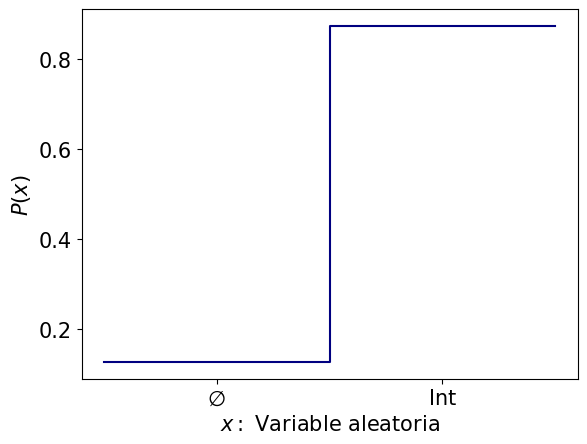

In [336]:
#Testeo
Px = P(t, uf, uc)
x = np.array([0, 1])

plt.plot(x, Px, ds = 'steps-mid', c = 'navy')
plt.xticks([0.25, 0.75], [r'$\emptyset$', 'Int'])
plt.ylabel(r'$P(x)$')
plt.xlabel(r'$x:$ Variable aleatoria')
plt.show()

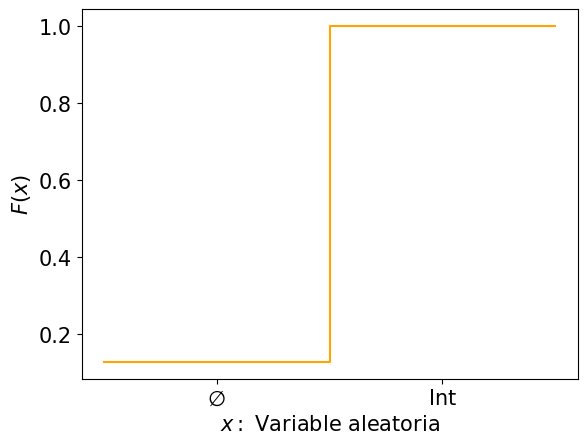

In [337]:
Fx = F(Px)

plt.plot(x, Fx, ds = 'steps-mid', c = 'orange')
plt.xticks([0.25, 0.75], [r'$\emptyset$', 'Int'])
plt.ylabel(r'$F(x)$')
plt.xlabel(r'$x:$ Variable aleatoria')
plt.show()

### Compton o Fotoeléctrico

In [338]:
def P_FC(uf, uc):
  '''
  Función de densidad de probabilidad para el caso de la interacción entre efecto Compton y Fotoeléctrico
  - uf: (float) - Coeficiente de atenuación lineal para el efecto Fotoeléctico en cm^-1
  - uc: (float) - Coeficiente de ateniación lineal para el efecto Compton en cm^-1
  '''
  u = uf + uc
  return np.array([uf/u, uc/u])

In [339]:
PFC = P_FC(uf, uc)
FFC = F(PFC)

print('Pasa derecho: ', Px[0])
print('Interactúa: ', Px[1])
print('Probabilidad relativa f: ', PFC[0])
print('Probabilidad relativa C: ', PFC[1])
print('Probabilidad absoluta f: ', Px[1]*PFC[0])
print('Probabilidad absoluta C: ', Px[1]*PFC[1])

Pasa derecho:  0.12645439652368565
Interactúa:  0.8735456034763144
Probabilidad relativa f:  0.11554690035702694
Probabilidad relativa C:  0.884453099642973
Probabilidad absoluta f:  0.10093548680219666
Probabilidad absoluta C:  0.7726101166741177


### Calibración

In [340]:
def Calibracion(E, a0=0, a1=1):
  '''
  Función que hace una tranformación del valor dela energía de keV a canal con los parámetros de la calibración canal-keV
  - a0: (float) parámetro de la calibración del corte con el eje y en keV
  - a1: (float) parámetro de la calibración de la pendiente de la función lineal en keV/canal
  '''
  return np.rint((E-a0)/a1).astype(int) #Canal

def Calibracion_EC(C, a0, a1):
  '''
  Función que hace una tranformación del valor dela energía de canal a keV
  - a0: (float) parámetro de la calibración del corte con el eje y en keV
  - a1: (float) parámetro de la calibración de la pendiente de la función lineal en keV/canal
  '''
  return a0+C*a1

### Compton

In [341]:
def P_C(E_e, E_gamma = 662):
  '''
  Función de densidad de probabilidad para el efecto Compton en función de la energía
  - E_e: (float) - Energía el electrón
  - E_gamma: (float) - Energía del fotón correspondiente al fotopico de 662 keV
  '''
  epsilon_e = E_e/E_gamma
  epsilon_gamma = E_gamma/511

  A = epsilon_e**2/(epsilon_gamma**2*(1-epsilon_e)**2)
  B = epsilon_e/(1-epsilon_e)
  C = epsilon_e-2/epsilon_gamma

  return 2 + A + B*C

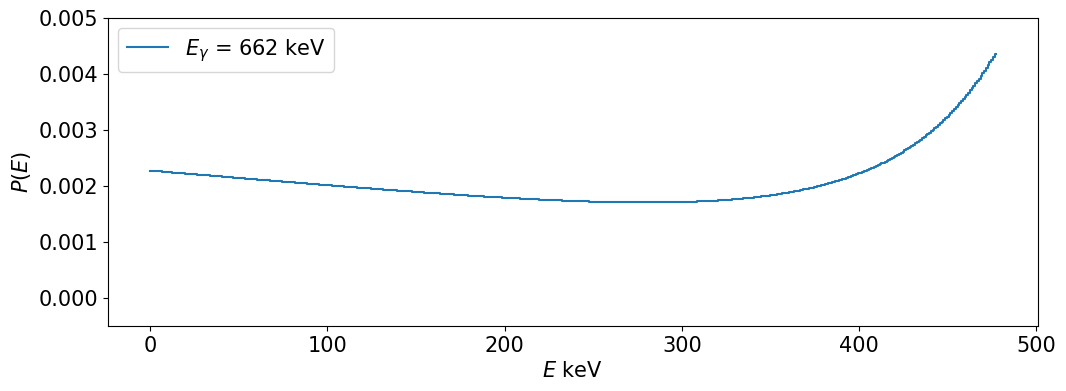

In [342]:
#BORDE COMPTON
E = 662
epsilon_g = E/511
EC = E*2*epsilon_g/(1+2*epsilon_g)

#Energia
dE = 1 #keV
Energias = np.arange(0, EC, dE)
PC = P_C(Energias)/(np.sum(P_C(Energias))*dE)

plt.figure(figsize = (12,4))
plt.plot(Energias, PC, ds = 'steps-mid', label = r'$E_\gamma$ = 662 keV')
plt.ylim(-0.0005, 0.005)
plt.xlabel(r'$E$ keV')
plt.ylabel(r'$P(E)$')
plt.legend()

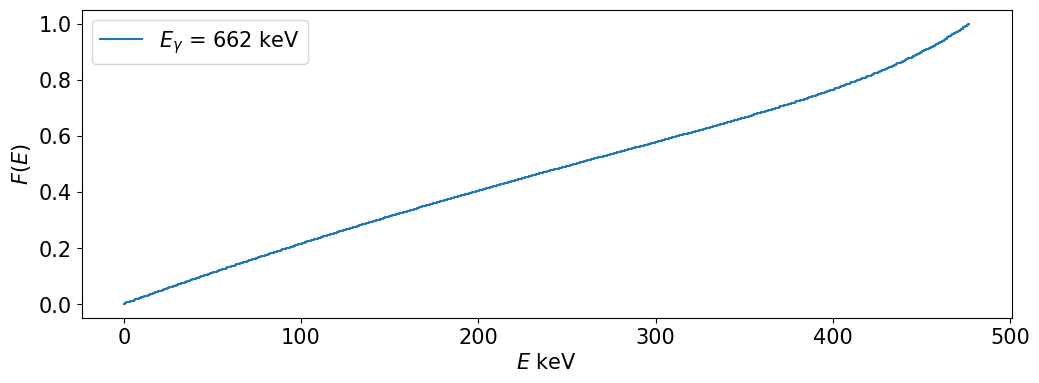

In [343]:
FC = F(PC)/F(PC)[-1]

plt.figure(figsize = (12,4))
plt.plot(Energias, FC, ds = 'steps-mid', label = r'$E_\gamma$ = 662 keV')
plt.xlabel(r'$E$ keV')
plt.ylabel(r'$F(E)$')
plt.legend()

### FWHM

In [344]:
def FWHM(E):
  '''
  Función que calcula el FWHM en función de la energía con los parámetros experimentales del detector de NaI
    - E: (float)
  '''
  c0 = 2.187797671616236
  c1 = 1.8626969127933153
  return c0+c1*np.sqrt(E)

### Gaussiana

In [345]:
def P_gaussiana(E, dE = 0.1):
  '''
  Función de densidad de probabilidad para una distribución gaussiana a partir de la energía de referencia
    - E: (float) - Energía del centroide de la gaussiana
    - dE: (float) - Discretización de la energía en intervalos de dE
  '''
  mu = E
  stdv = FWHM(E)/(2*np.sqrt(2*np.log(2)))

  Emin = mu-4*stdv
  Emax = mu+4*stdv

  while Calibracion(Emin)<=0:
    Emin+=0.2

  if 0<Calibracion(Emin):
    E_vals = np.arange(Emin, Emax, dE)
    gaussiana = (1/(stdv*np.sqrt(2*np.pi)))*np.exp((-1/2)*((E_vals-mu)/stdv)**2)

    E_vals1 = E_vals
    gaussiana1 = gaussiana

  return E_vals1, gaussiana1/(np.sum(gaussiana)*dE)

### Cálculo de $\lambda$

In [346]:
u = uf + uc
l_lambda = 1/u

print('Lambda: ', l_lambda, 'cm')
print('Lambda: ', l_lambda/2.54, 'pulgadas')
print('mu: ', u, 'cm^-1')
print('t: ', t, 'cm')
print('t: ', t_inch, 'pulgadas')
print('t/lambda: ', t/l_lambda)

Lambda:  3.6849448776465645 cm
Lambda:  1.4507656998608522 pulgadas
mu:  0.27137448 cm^-1
t:  7.62 cm
t:  3 pulgadas
t/lambda:  2.0678735375999997


## Implementación

In [347]:
def decaimiento(N_0, t, uf, uc, E=662, N_Canales = 1024, a0 = 0, a1 = 1, Normalize=False, Width = True, Plot = True):
  '''
    Función que realiza la simulación del decaimiento exponencial.

    A partir del número inicial de núcleos, determina a partir del método de MonteCarlo,
    el intervalo de tiempo en el que decae según la función acumulativa de la distribución
    de probabilidad exponencial.

    Retorna un arreglo con el histograma del conteo de los decaimientos en cada instante de t.

    - N_0: (int) - Número inicial de fotones
    - t: (float) - Grosor del Detector
    - uf: (float) - Probabilidad de interacción por unidad de longitud (Coeficiente de atenuación lineal) por efecto Fotoeléctrico
    - uc: (float) - Probabilidad de interacción por unidad de longitud (Coeficiente de atenuación lineal) por efecto Compton
    - E: (float) - Energía del fotopico
    - N_Canales: (int) - Número de canales utilizados
    - a0: (float) parámetro de la calibración del corte con el eje y en keV
    - a1: (float) parámetro de la calibración de la pendiente de la función lineal en keV/canal
    - Normalize: (bool) - Argumento para decidicir si el histograma está normalizado
    - Width: (bool) - Incluir la distribución de las cuentas en forma de na distribución gaussiana alrededor del canal centroide
    - Plot: (bool) - Graficar o No, el espectro obtenido por la simulación
  '''

  cuentas = np.zeros(N_Canales) #Cuentas en cada canal
  canales = np.arange(0, N_Canales, 1) #Canales

  #Probabiliad e Interacción
  Px = P(t, uf, uc)
  Fx = F(Px)
  histograma = np.zeros_like(Fx) #No Int o Int

  #Interacción por efecto Compton o efecto Fotoeléctrico
  PFC = P_FC(uf, uc)
  FFC = F(PFC)

  #Efecto Compton
  epsilon_g = E/511
  EC = E*2*epsilon_g/(1+2*epsilon_g)

  #Energia
  dE = 1 #keV
  Energias = np.arange(0, EC, dE)
  PC = P_C(Energias)/(np.sum(P_C(Energias))*dE)
  FC = F(PC)/F(PC)[-1]

  #Simulación por Monte Carlo
  for i in range(N_0):
      r = rn.random()
      for j in range(1, len(Fx)):
      #NO Interactua
        if r >= 0 and r < Fx[0]:
          bingo = 0
          break

      #Interactua
        elif r > Fx[j-1] and r <= Fx[j]:

            bingo = j #Int - No Int

            r_fc = rn.random() #Nuevo Random

            for k in range(1, len(FFC)):

              if r_fc >= 0 and r_fc < FFC[0]: #Fotoeléctrico

                E_C = Calibracion(E, a0, a1) #keV to Canal -> Canal-keV function

                if Width:
                  #gaussiana
                  EG, PG = P_gaussiana(E)
                  FG = F(PG)/np.max(F(PG))
                  r_g = rn.random()
                  for jj in range(1,len(FG)):
                    if r_g >= 0 and r_g < FG[0]:
                      #Elegir Energía nueva
                      EN = Calibracion(EG[0], a0, a1)

                      break

                    elif r_g > FG[jj-1] and r_g <= FG[jj]:
                      EN = Calibracion(EG[jj], a0, a1)

                      break

                  cuentas[EN]+=1

                else:
                  cuentas[E_C]+=1

              elif r > Fx[k-1] and r <= Fx[k]: #Compton

                r_c = rn.random()

                for ii in range(1, len(FC)):
                  if r_c >= 0 and r_c < FC[0]:
                    E_e = 0
                    bingo_c = Calibracion(E_e, a0, a1)
                    if Width:
                      #gaussiana
                      EG, PG = P_gaussiana(bingo_c)
                      FG = F(PG)/np.max(F(PG))
                      r_g = rn.random()
                      for jj in range(1,len(FG)):
                        if r_g >= 0 and r_g < FG[0]:
                          #Elegir Energía nueva
                          EN = Calibracion(EG[0], a0, a1)
                          break
                        elif r_g > FG[jj-1] and r_g <= FG[jj]:
                          EN = Calibracion(EG[jj], a0, a1)
                          break

                      cuentas[EN]+=1

                    else:
                      cuentas[bingo_c]+=1

                    break

                  elif r_c > FC[ii-1] and r_c <= FC[ii]:
                    E_e = Energias[ii]
                    bingo_c = Calibracion(E_e, a0, a1)

                    if Width:
                      #gaussiana
                      EG, PG = P_gaussiana(bingo_c)
                      FG = F(PG)/np.max(F(PG))
                      r_g = rn.random()
                      for jj in range(1,len(FG)):
                        if r_g >= 0 and r_g < FG[0]:
                          #Elegir Energía nueva
                          EN = Calibracion(EG[0], a0, a1)

                          break
                        elif r_g > FG[jj-1] and r_g <= FG[jj]:
                          EN = Calibracion(EG[jj], a0, a1)
                          break

                      cuentas[EN]+=1
                    else:
                      cuentas[bingo_c]+=1

              break
      histograma[bingo] += 1
  if Normalize == True:
    histograma/= N_0

  #Espectro
  if Plot:
    plt.show()
    print('Espectro de Emisión')
    plt.figure(figsize=(13,5))
    plt.plot(canales, cuentas, c = 'navy', ds = 'steps-mid', label = r'$E_\gamma$= 662 keV')
    plt.ylabel('$I$ (cuentas/canal)')
    plt.xlabel('$E$ (canal)')
    plt.legend()
    plt.show()

  return histograma, cuentas

### Número de Fotones

In [348]:
N0 = int(1e6) #Fotones

### Sin Incluir el FWHM

In [349]:
Hist_A, Counts_A = decaimiento(N0, t, uf, uc, Width = False, Plot = False)

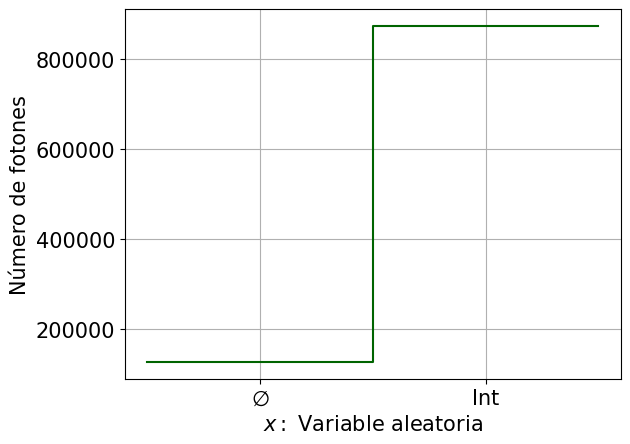

In [390]:
xA = np.array([0, 1])
plt.plot(xA, Hist_A, ds = 'steps-mid', c = 'darkgreen')
plt.xticks([0.25, 0.75], [r'$\emptyset$', 'Int'])
plt.ylabel(r'Número de fotones')
plt.xlabel(r'$x:$ Variable aleatoria')
plt.grid()
plt.show()

In [350]:
Channels = np.arange(0, 1024, 1)
Energy_C = Calibracion_EC(Channels, 0, 1)

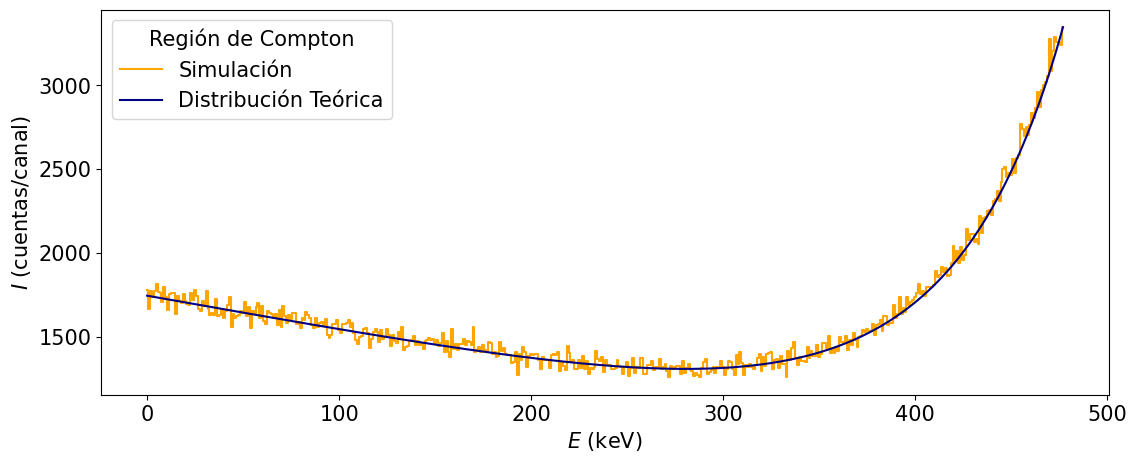

In [351]:
E_Compton = Energias
EC_Channel = Calibracion(EC)
Compton_Sim = Counts_A[:round(EC)]
Compton = PC*np.max(Compton_Sim)/np.max(PC)


plt.figure(figsize = (13, 5))
plt.plot(E_Compton, Compton_Sim, ds = 'steps-mid', c = 'orange', label = 'Simulación')
plt.plot(E_Compton, Compton, c = 'navy', label = 'Distribución Teórica')
plt.xlabel(r'$E$ (keV)')
plt.ylabel(r'$I$ (cuentas/canal)')
plt.legend(title=r'Región de Compton')
plt.show()

### Incluyendo el FWHM

In [352]:
Hist, Counts = decaimiento(N0, t, uf, uc, Plot = False)

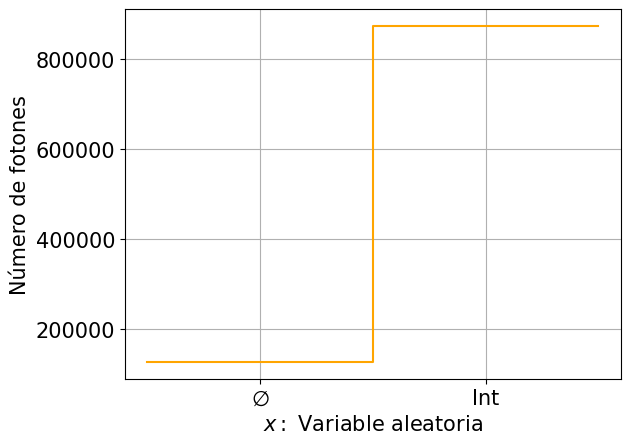

In [391]:
x2 = np.array([0, 1])
plt.plot(x2, Hist, ds = 'steps-mid', c = 'orange')
plt.xticks([0.25, 0.75], [r'$\emptyset$', 'Int'])
plt.ylabel(r'Número de fotones')
plt.xlabel(r'$x:$ Variable aleatoria')
plt.grid()
plt.show()

## Comparación espectro simulado y espectro experimental

### Espectro experimental

Para realizar la comparación del espectro experimental con el obtenido por la simulación, es necesario tener los archivos descargados y tener la ubicación de los mismos.

Los archivos requeridos son:
 - Datos del espectro de $^{137}$Cs (cuentas, canal)
 - Datos del fondo de la medición (cuentas, canal)

#### Datos

In [353]:
# Cargar los archivos
drive.mount('/content/drive') #En este caso, se había trabajado en drive

#Ubicación del Archivo, por favor cambiar esto al correr el código:
path = '/content/drive/MyDrive/1. Universidad/Instrumentación nuclear /Prácticas/Práctica 2/Datos/'

#Cargar los archivos
Cs137 =  pd.read_table(path + '10 min/NaI_137Cs_600s.dat', delimiter = '\s+')
Fondo600 = pd.read_table(path + '10 min/NaI_Fondo_600s.dat', delimiter = '\s+')
NewCs137 = Cs137['cuentas'] - Fondo600['cuentas']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Comparación con la Simulación

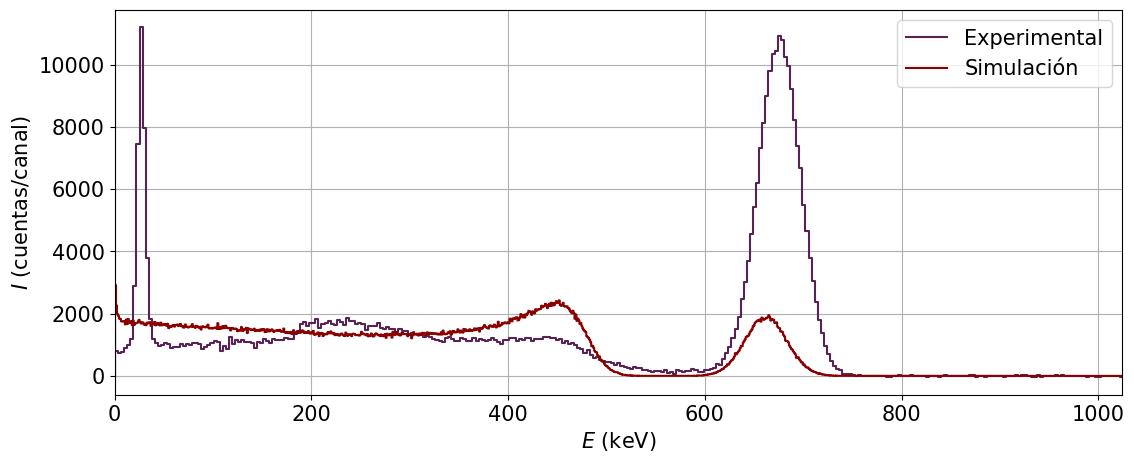

In [377]:
#Calibración
Cs_energia=Calibracion_EC(Cs137['canal'], a0=-38.82898815, a1=3.13345234)

#Gráfica
plt.figure(figsize=(13,5))
plt.plot(Cs_energia, NewCs137, ds = 'steps-mid', c = np.random.rand(3,), label = 'Experimental')
plt.plot(Energy_C, Counts, ds = 'steps-mid', c = 'darkred', label = 'Simulación')
plt.xlim(0,1024) #Rango comparable
plt.grid()
plt.xlabel(r'$E$ (keV)')
plt.ylabel(r'$I$ (cuentas/canal)')
plt.legend()

### Misma Calibración canal-keV y normalización respecto a la altura del borde de Compton

In [355]:
a0 = -38.82898815
a1 = 3.13345234

#Simulación con los parámetros de la calibración experimental
HistB, CountsB = decaimiento(N0, t, uf, uc, a0 = a0, a1 = a1, Plot = False)

In [356]:
#Energía máxima del borde de Compton para normalizar
Max_Compton_Exp = np.max(NewCs137[100:500])

#Energía del borde de Compton en canales
EC_Channel = Calibracion(EC, a0, a1)

#Restricción de las cuentas para el rango de las energías hasta el borde de Compton
Compton_Sim = CountsB[:EC_Channel]

#Renormalización
Counts_B = CountsB*Max_Compton_Exp/np.max(CountsB[100:500])

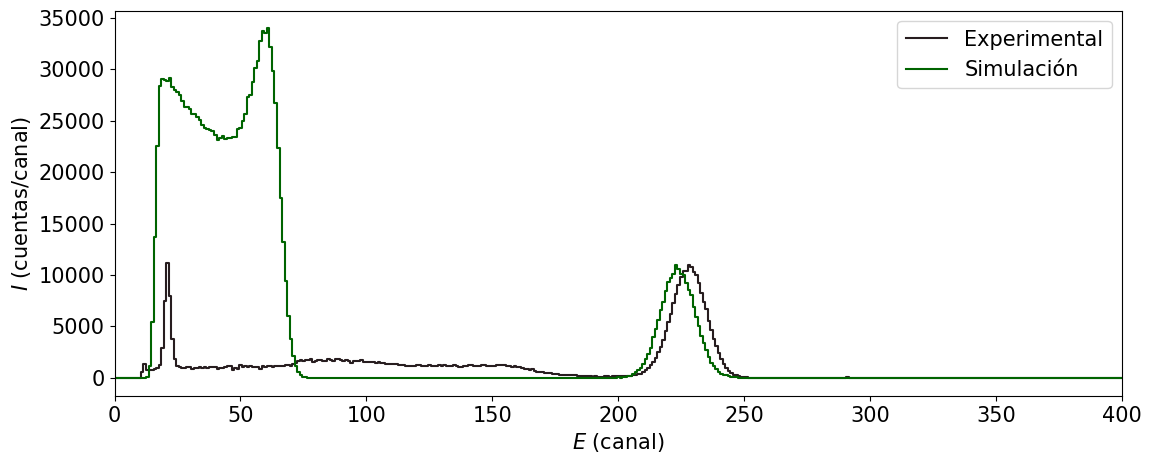

In [373]:
#Comparación
E_Calib = Calibracion_EC(Channels, a0= a0, a1 = a1)
plt.figure(figsize=(13,5))
plt.grid()
plt.plot(Cs137['canal'], NewCs137, ds = 'steps-mid', c = np.random.rand(3,), label = r'Experimental')
plt.plot(Channels, Counts_B, ds = 'steps-mid', c = 'darkgreen', label = 'Simulación')
plt.grid()

plt.xlabel(r'$E$ (canal)')
plt.ylabel(r'$I$ (cuentas/canal)')
plt.xlim(0, 400)
plt.legend()